Total classes: 15

Image count per class: 

label
calling               840
clapping              840
cycling               840
dancing               840
drinking              840
eating                840
fighting              840
hugging               840
laughing              840
listening_to_music    840
running               840
sitting               840
sleeping              840
texting               840
using_laptop          840 



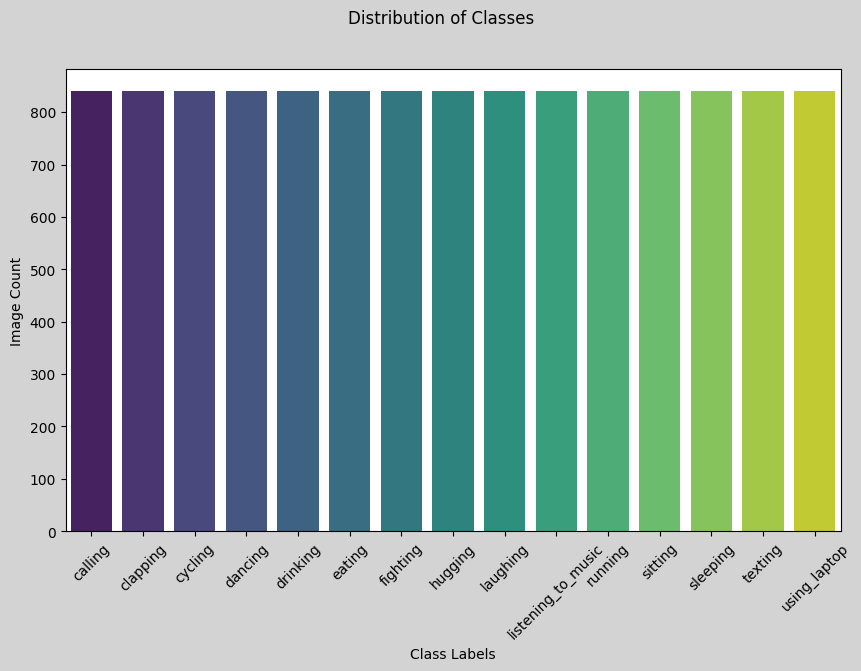

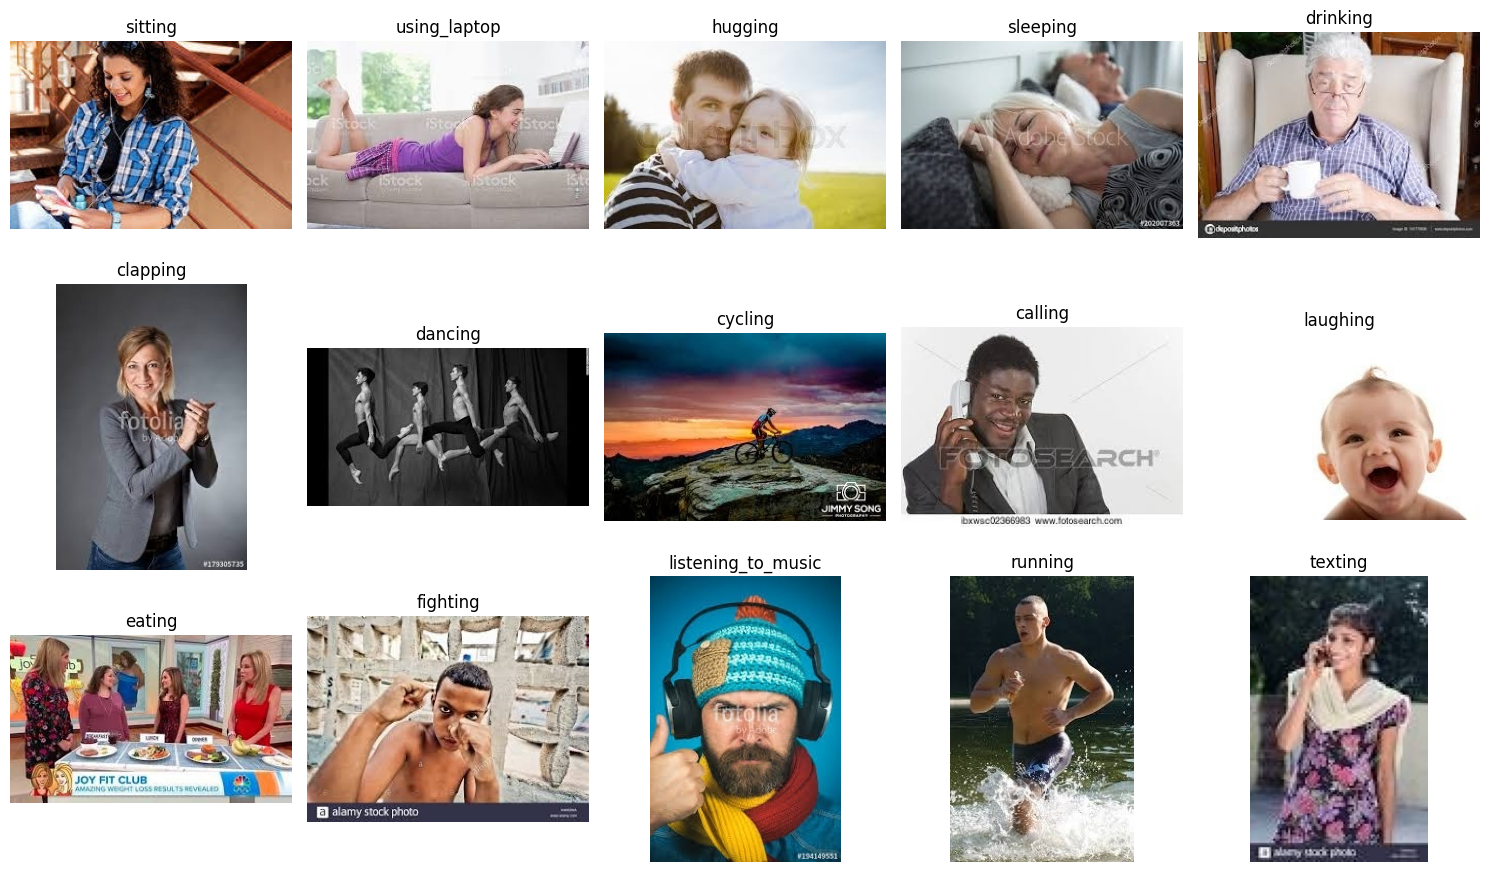

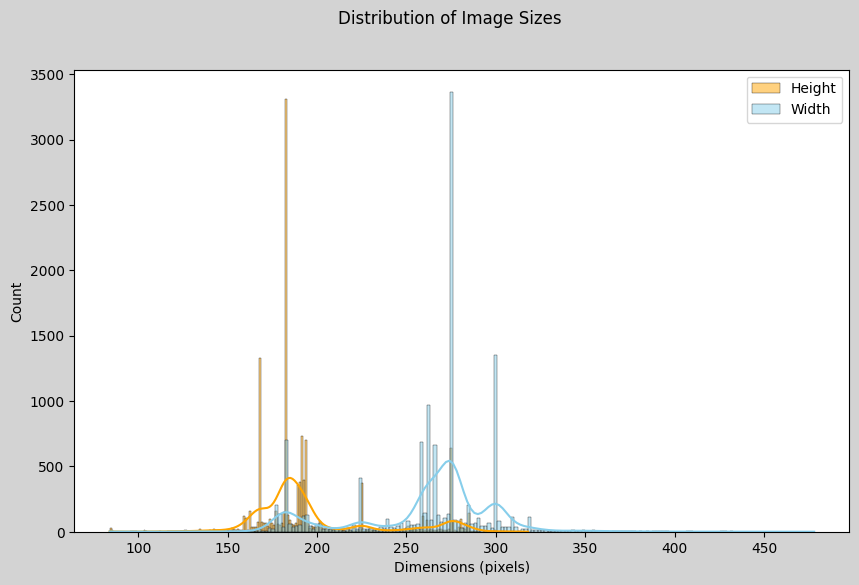

Statistics of image dimensions:
              width        height
count  12600.000000  12600.000000
mean     260.381032    196.573571
std       39.919281     35.281402
min       84.000000     84.000000
25%      254.000000    181.000000
50%      275.000000    183.000000
75%      276.000000    194.000000
max      478.000000    318.000000

No major class imbalances found.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Loading the dataset
Data = pd.read_csv('label.csv')

# Counting the number images in each class
Images_Per_Class_count = Data.groupby('label').size()
Number_Of_Classes = Data['label'].drop_duplicates().count()

# Distribution of image sizes
i_f = 'data/'
img_sizes = []
i = 0

while i < len(Data):
    image_name = Data.at[i, 'filename']
    image_path = f"{i_f}/{image_name}"
    with Image.open(image_path) as img:
        img_sizes.append(img.size)
    i += 1

# Creating a DataFrame for further analysis
img_sizes_df = pd.DataFrame.from_records(img_sizes, columns=['width', 'height'])

# Output
print(f"Total classes: {Number_Of_Classes}\n")
print(f"Image count per class: \n")
print(f"{Images_Per_Class_count.to_string()} \n")

# Visualizing the class distribution
plt.figure(figsize=(10, 6), facecolor='lightgray')
sns.barplot(x=Images_Per_Class_count.index, y=Images_Per_Class_count.values, hue=Images_Per_Class_count.index, palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.suptitle('Distribution of Classes')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')
plt.show()

# Displaying Sample images for visualization
s_i = Data.drop_duplicates(subset=['label'])
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
j = 0
while j < len(s_i):
    ax = axes.ravel()[j]
    filename = s_i.iloc[j, 0] 
    label = s_i.iloc[j, 1]     
    image_path = f"{i_f}/{filename}"
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"{label}")
    ax.set_axis_off()
    j += 1

plt.tight_layout()
plt.show()

# Visualizing the distribution of image sizes
plt.figure(figsize=(10, 6), facecolor='lightgray')
sns.histplot(img_sizes_df['height'], kde=True, color='orange', label='Height')
sns.histplot(img_sizes_df['width'], kde=True, color='skyblue', label='Width')
plt.xlabel('Dimensions (pixels)')
plt.suptitle('Distribution of Image Sizes')
plt.legend()
plt.show()

# Displaying image size statistics
stats = img_sizes_df.describe()
print(f"Statistics of image dimensions:\n{stats}\n")

# Detecting class imbalance
i_c = Images_Per_Class_count[Images_Per_Class_count < (0.1 * len(Data) / Number_Of_Classes)]

# Output
if i_c.empty:
    print("No major class imbalances found.")
else:
    print(f"Classes with image counts below the defined threshold: {i_c}")

In [3]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import hog, local_binary_pattern

# Function to extract HOG features dynamically based on image size
hog_features = []
def extract_hog_features(image):
    # Dynamically determine pixels_per_cell and cells_per_block based on image size
    hog_features, _ = hog(image, orientations=9, pixels_per_cell=(image.shape[0] // 8, image.shape[1] // 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True, feature_vector=True)
    return hog_features

# Function to extract LBP features
lbp_features = []
def extract_lbp_features(image):
    (hist, _) = np.histogram(local_binary_pattern(image, P=24, R=3, method='uniform').ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist / hist.sum()
    return hist

# Function to extract color histogram features in different color spaces
color_hist_features = []
def extract_color_histogram(image):
    # Convert to HSV and Lab color spaces and extract histograms
    hist_features = []

    # List of images in different color spaces
    images = [image, cv2.cvtColor(image, cv2.COLOR_BGR2HSV), cv2.cvtColor(image, cv2.COLOR_BGR2Lab)]
    k = 0
    while k < len(images):
        img = images[k]
        hist = cv2.calcHist([img], [0, 1, 2], None, [16]*3, [0, 256]*3)
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
        k += 1

    return hist_features

# Function to extract GLCM features using multiple distances and angles
glcm_features = []
def extract_glcm_features(image):
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different angles
    temp = []
    distances = [1, 2, 3]  # Different distances

    n = 0
    while n < len(distances):
        m = 0
        while m < len(angles):
            glcm = graycomatrix(image, [distances[n]], [angles[m]], 256, symmetric=True, normed=True)
            temp.extend([graycoprops(glcm, 'contrast')[0, 0], graycoprops(glcm, 'dissimilarity')[0, 0], graycoprops(glcm, 'homogeneity')[0, 0], graycoprops(glcm, 'energy')[0, 0], graycoprops(glcm, 'correlation')[0, 0], graycoprops(glcm, 'ASM')[0, 0]])
            m += 1
        n += 1
    return temp

# Function to extract edge orientation and density features
edge_density = []
def extract_edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    orientation = np.arctan2(cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=5), cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=5)).flatten()
    orientation_hist, _ = np.histogram(orientation, bins=30, range=(-np.pi, np.pi))
    var = edges.sum() / edges.size
    edge_density = np.array([var])
    return np.concatenate((edge_density, orientation_hist))

# Iterate over each image and extract features
image_labels = []
index = 0
while index < len(Data):
    row = Data.iloc[index]
    image_path = f"data/{row['filename']}"
    
    # Loading image in grayscale for HOG, LBP, and GLCM
    image_gray = cv2.imread(image_path, 0) # 0 is equivalent to cv2.IMREAD_GRAYSCALE
    image_color = cv2.imread(image_path, 1) # 1 is equivalent to cv2.IMREAD_COLOR
        
    # Extracting HOG features
    hog_features.append(extract_hog_features(image_gray))

    # Extracting color histogram features
    color_hist_features.append(extract_color_histogram(image_color))
    
    # Extracting LBP features
    lbp_features.append(extract_lbp_features(image_gray))
    
    # Extracting GLCM features
    glcm_features.append(extract_glcm_features(image_gray))
    
    # Extracting edge density feature
    edge_density.append(extract_edge_density(image_gray))
    
    # Storing the corresponding label
    image_labels.append(row['label'])

    print(f"Processed {index + 1}/{len(Data)} images")
    
    index += 1


all_features = np.concatenate((np.array(hog_features), np.array(color_hist_features), np.array(lbp_features), np.array(glcm_features), np.array(edge_density)), axis=1)

# Display feature array shape
print(f"Combined Feature Array Shape: {all_features.shape}")

Processed 1/12600 images
Processed 2/12600 images
Processed 3/12600 images
Processed 4/12600 images
Processed 5/12600 images
Processed 6/12600 images
Processed 7/12600 images
Processed 8/12600 images
Processed 9/12600 images
Processed 10/12600 images
Processed 11/12600 images
Processed 12/12600 images
Processed 13/12600 images
Processed 14/12600 images
Processed 15/12600 images
Processed 16/12600 images
Processed 17/12600 images
Processed 18/12600 images
Processed 19/12600 images
Processed 20/12600 images
Processed 21/12600 images
Processed 22/12600 images
Processed 23/12600 images
Processed 24/12600 images
Processed 25/12600 images
Processed 26/12600 images
Processed 27/12600 images
Processed 28/12600 images
Processed 29/12600 images
Processed 30/12600 images
Processed 31/12600 images
Processed 32/12600 images
Processed 33/12600 images
Processed 34/12600 images
Processed 35/12600 images
Processed 36/12600 images
Processed 37/12600 images
Processed 38/12600 images
Processed 39/12600 im

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2009  2013  2500 ... 14049 14050 14051] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Naive Bayes Accuracy: 0.1798
Decision Tree Accuracy: 0.1893
Random Forest Accuracy: 0.3837
Perceptron Accuracy: 0.2635
Ensemble Random Forest Accuracy: 0.3786
                    Model  Accuracy
0             Naive Bayes  0.179762
1           Decision Tree  0.189286
2           Random Forest  0.383730
3              Perceptron  0.263492
4  Ensemble Random Forest  0.378571


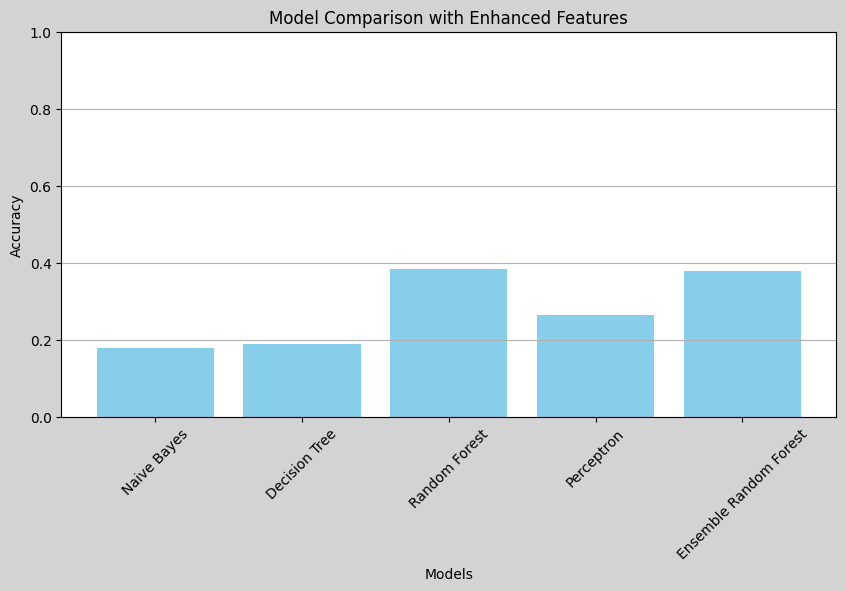

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import pickle
labels_array = np.array(image_labels)
all_features_selected = SelectKBest(f_classif, k=5500).fit_transform(all_features, labels_array)

# Preparing the dataset with all extracted features
labels = labels_array
features = all_features_selected 

# Dividing the dataset into training (80%) and testing (20%) subsets
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=1 - train_size, random_state=42, stratify=labels)

# Standardizing the features for better model performance
X_train_scaled = StandardScaler().fit(X_train).transform(X_train)
X_test_scaled = StandardScaler().fit(X_train).transform(X_test)

# Initialize models
rf1 = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=42)
rf2 = RandomForestClassifier(n_estimators=1000, max_depth=30, random_state=42)
rf3 = RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_split=5, random_state=42)
rf4 = RandomForestClassifier(n_estimators=600, max_depth=40, min_samples_leaf=2, random_state=42)
rf5 = RandomForestClassifier(n_estimators=700, max_depth=25, min_samples_split=3, random_state=42)

# Train and evaluate each model
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest':  RandomForestClassifier(n_estimators=1450, random_state=42),
    'Perceptron': Perceptron(random_state=42)
}

results = {}

names = list(models.keys())
t = 0
while t < len(names):
    name = names[t]
    current_model = models.get(name)
    current_model.fit(X_train_scaled, y_train)
    predictions = current_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, predictions)
    results.update({name: acc})
    print(f"{name} Accuracy: {acc:.4f}")
    t += 1


# Combining the 5 classifiers using VotingClassifier with 'hard' voting
voting_clf = VotingClassifier(estimators=[
    ('rf1', rf1), 
    ('rf2', rf2), 
    ('rf3', rf3), 
    ('rf4', rf4), 
    ('rf5', rf5),
], voting='hard')

# Fitting the voting classifier on the training data
voting_clf.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = voting_clf.predict(X_test_scaled)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Random Forest Accuracy: {accuracy:.4f}")
results['Ensemble Random Forest'] = accuracy
with open('2021331_model.pkl', 'wb') as file:
    pickle.dump(models['Random Forest'], file)
# Documenting the results in a DataFrame for comparison
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Displaying results using pandas DataFrame
print(results_df)

# Plot the results for better visualization
plt.figure(figsize=(10, 5),facecolor='lightgray')
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Model Comparison with Enhanced Features')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [7]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import pickle

labels_array = np.array(image_labels)
all_features_selected = SelectKBest(f_classif, k=5500).fit_transform(all_features, labels_array)

# Preparing the dataset with all extracted features
labels = labels_array
features = all_features_selected 

# Dividing the dataset into training (80%) and testing (20%) subsets
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=1 - train_size, random_state=42, stratify=labels)

# Standardizing the features for better model performance
X_train_scaled = StandardScaler().fit(X_train).transform(X_train)
X_test_scaled = StandardScaler().fit(X_train).transform(X_test)
with open('2021331_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
loaded_model.fit(X_train_scaled, y_train)
y_pred = loaded_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2009  2013  2500 ... 14049 14050 14051] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Accuracy: 0.3837
